In [1]:
import rescomp as rc
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

## ODE data

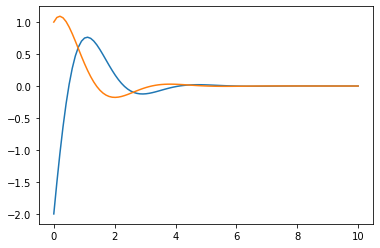

In [2]:
def f(y,t):
    """ 2D ODE (y should be a numpy array length 2)"""
    A = -1*np.array([[1.0, -3.0], [1.0, 1.0]])
    return A @ y

y0 = [-2, 1]
t = np.linspace(0, 10, 100)
# Solve ODE
Y = integrate.odeint(f, y0, t)
# Plot
plt.plot(t, Y)
plt.show()

## Train RC

Uses the standard training algorithm, but doesn't set initial conditions randomly and doesn't discard transients.

In [52]:
rcomp = rc.ResComp(signal_dim=2)
# Train on first 90 time steps
rcomp.train(t[:90], Y[:90,:])
# Last state of reservoir nodes during training as initial condition
r0 = rcomp.r0
# Predict final 10
pre = rcomp.predict(t[90:], r0=r0)

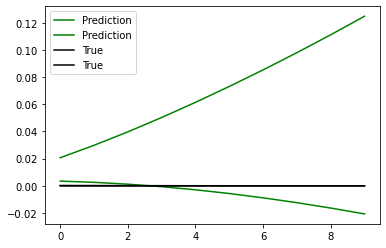

In [53]:
plt.plot(pre, c='g', label="Prediction")
plt.plot(Y[90:,:], c="k", label="True")
plt.legend()
plt.show()

This is a failure, due to not enough data, and no parameter optimization

## New training method
 Notice how this still uses the last state of the reservoir nodes during training as the initial condition for the prediction but breaks the data into overlapping windows with the `window` and `overlap` parameters

In [22]:
rcomp = rc.ResComp(signal_dim=2)
# Train on first 90 time steps with NEW METHOD
rcomp.train(t[:90], Y[:90,:], window=1, overlap=.95)
# Last state of reservoir nodes during training as initial condition
r0 = rcomp.r0 
# Predict final 10
pre = rcomp.predict(t[90:], r0=r0)

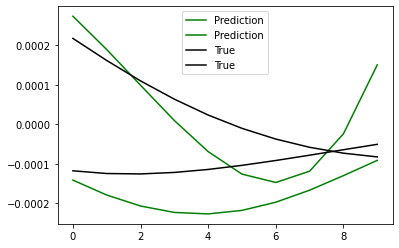

In [23]:
plt.plot(pre, c='g', label="Prediction")
plt.plot(Y[90:,:], c="k", label="True")
plt.legend()
plt.show()

Better prediction

## Different initial condition mappings
The training above used the reservoir training ODE steady state as the initial condition by default. We will look at two other initial condition mappings

#### Fixed point mapping (Non linear solver)

In [29]:
rcomp = rc.ResComp(signal_dim=2, map_initial="fixed point")
# Train on first 90 time steps with NEW METHOD
rcomp.train(t[:90], Y[:90,:], window=1, overlap=.95)
# Last state of reservoir nodes during training as initial condition
r0 = rcomp.r0
# Predict final 10
pre = rcomp.predict(t[90:], r0=r0)

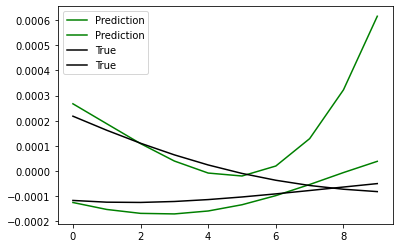

In [30]:
plt.plot(pre, c='g', label="Prediction")
plt.plot(Y[90:,:], c="k", label="True")
plt.legend()
plt.show()

A little worse. (See the y axis compared to the y axis above)

#### The made up mapping

In [40]:
rcomp = rc.ResComp(signal_dim=2, map_initial="activ_f")
# Train on first 90 time steps with NEW METHOD
rcomp.train(t[:90], Y[:90,:], window=1, overlap=.95)
# Last state of reservoir nodes during training as initial condition
r0 = rcomp.r0
# Predict final 10
pre = rcomp.predict(t[90:], r0=r0)

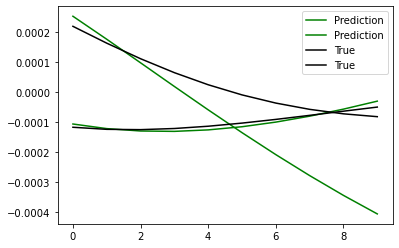

In [41]:
plt.plot(pre, c='g', label="Prediction")
plt.plot(Y[90:,:], c="k", label="True")
plt.legend()
plt.show()

To me this is better than the other two, but we didn't do any parameter optimization so we can't say anything in general. 

### Initial Conditions

Instead of using the last reservoir state as the initial condition, we are going to take initial conditions from the ODE solution and see how well the reservoir maps them to the right place. Pay attention to the error at time t=9 because this is where we see how well the initial condition mapping sends ODE data to the right location in the reservoir node space.

#### Psuedoinverse and standard training method

After training normally, assign the initial reservoir node condition with $W_\text{out}^\dagger u(T)$ where $T$ is the time where the training data ends and testing data begins

In [46]:
rcomp = rc.ResComp(signal_dim=2, map_initial="fixed point")
# Train on first 90 time steps with NEW METHOD
rcomp.train(t[:90], Y[:90,:])
rcomp.map_initial="pseudoinverse"
# Predict final 10
pre = rcomp.predict(t[90:], u0=Y[90,:])

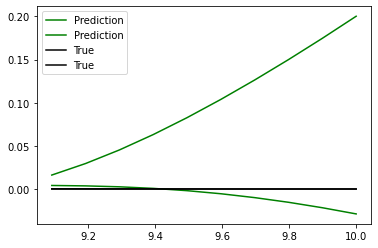

In [47]:
plt.plot(t[90:,], pre, c='g', label="Prediction")
plt.plot(t[90:], Y[90:,:], c="k", label="True")
plt.legend()
plt.show()

Notice how the pseudo inversedidn't map the initial condition very accurately (At t=9). That's why people let `r0` carry over from training like I did before.

#### New Method and Reservoir ODE Steady State Mapping

Break training data into overlapping windows and assign initial conditions with the reservoir training ODE steady state given $u(t) = u_0$

In [48]:
rcomp = rc.ResComp(signal_dim=2)
# Train on first 90 time steps with NEW METHOD
rcomp.train(t[:90], Y[:90,:], window=1, overlap=.95)
# Predict final 10
pre = rcomp.predict(t[90:], u0=Y[90,:])

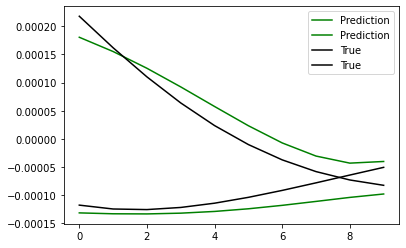

In [49]:
plt.plot(pre, c='g', label="Prediction")
plt.plot(Y[90:,:], c="k", label="True")
plt.legend()
plt.show()

A clear improvement, probably our best prediction yet!

#### New Method and ODE Made Up Mapping

Break data into overlapping windows and use the made up mapping to associate initial conditions

In [50]:
rcomp = rc.ResComp(signal_dim=2, map_initial="activ_f")
# Train on first 90 time steps with NEW METHOD
rcomp.train(t[:90], Y[:90,:], window=1, overlap=.95)
# Predict final 10
pre = rcomp.predict(t[90:], u0=Y[90,:])

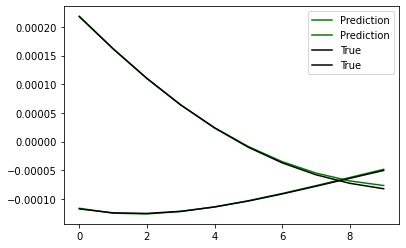

In [51]:
plt.plot(pre, c='g', label="Prediction")
plt.plot(Y[90:,:], c="k", label="True")
plt.legend()
plt.show()

Even better! Unbelievable! Why????